In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline, BarycentricInterpolator, SmoothBivariateSpline
import pandas as pd

plt.rcParams.update({'text.usetex':True}) # Nicer looking plots with proper TeX rendering

In [2]:
img = Image.open('data/BKmumu_LHCb.png') # https://arxiv.org/abs/1612.07818
imgH = img.convert('HSV')

## Axis calibration

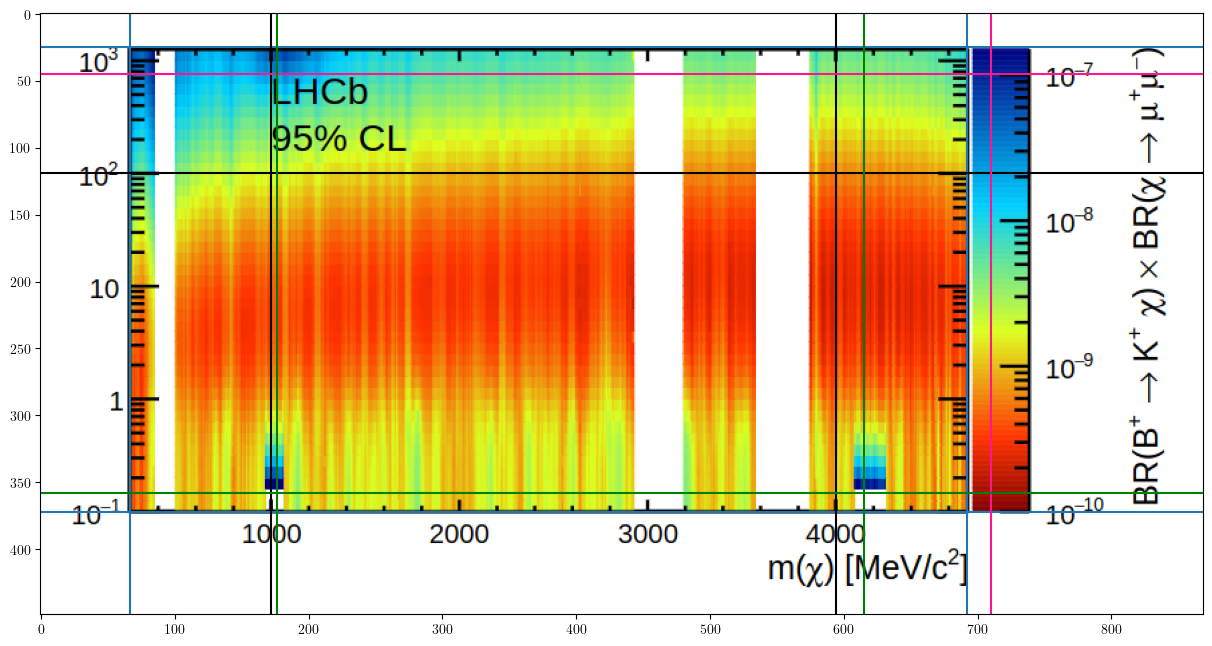

In [3]:
plt.figure(figsize=(15,15))
plt.imshow(np.asarray(img))

# Plot limits
plt.axvline(66.5) # Left
plt.axvline(692) # Right
plt.axhline(372) # Bottom; tau=0.1ps; BR=1e-10
plt.axhline(25) # Top

# Reference values)
plt.axvline(172, c='k') # ma=1GeV
plt.axvline(594, c='k') # ma=4GeV
plt.axhline(119, c='k') # tau=100ps

# Colorbar reference line
plt.axvline(710, c='deeppink')
plt.axhline(45, c='deeppink') # BR=1e-7

# Lines passing through excluded regions
plt.axhline(358, c='green')
plt.axvline(176, c='green')
plt.axvline(615, c='green')

In [4]:
ma2x = BarycentricInterpolator([1.0, 4.0], [172, 594])
x2ma = BarycentricInterpolator([172, 594], [1,4])

logtau2y = BarycentricInterpolator([-1, 2], [372, 119])
y2logtau = BarycentricInterpolator([119, 372], [2, -1])

In [5]:
def tau2y(tau):
    return (119-372)/3*np.log10(tau)+372+(119-372)/3

## Colorbar interpolation

In [6]:
def y2logbr(y):
    return (3*y-3*372)/(45-372)-10

def logbr2y(logbr):
    return (logbr+10+3*372/(45-372))/(3/(45-372))

Text(0, 0.5, 'Hue')

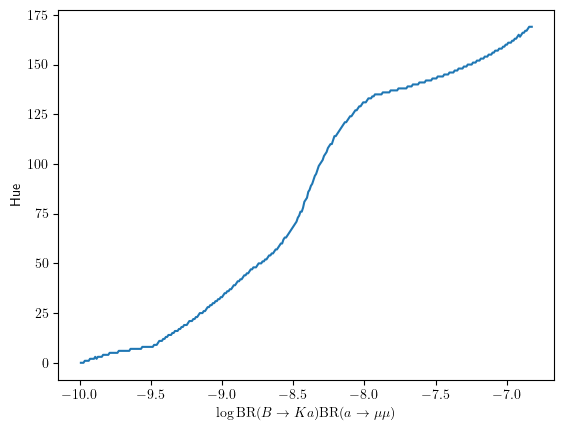

In [7]:
cbar = []
for y in range(26, 372):
    cbar.append(imgH.getpixel((710, y))[0])

plt.plot([y2logbr(y) for y in range(26, 372)] ,cbar)
plt.xlabel(r'$\log \mathrm{BR}(B\to Ka) \mathrm{BR}(a\to \mu\mu)$')
plt.ylabel('Hue')

In [8]:
cbar_dict = {cbar[i]: y2logbr(i+26) for i in range(len(cbar))}

In [9]:
hue2logbr = CubicSpline(list(reversed(cbar_dict.keys())), list(reversed(cbar_dict.values())))

## Exclude areas in the plot that are white (quarkonia resonances) or black (plot ticks, text)

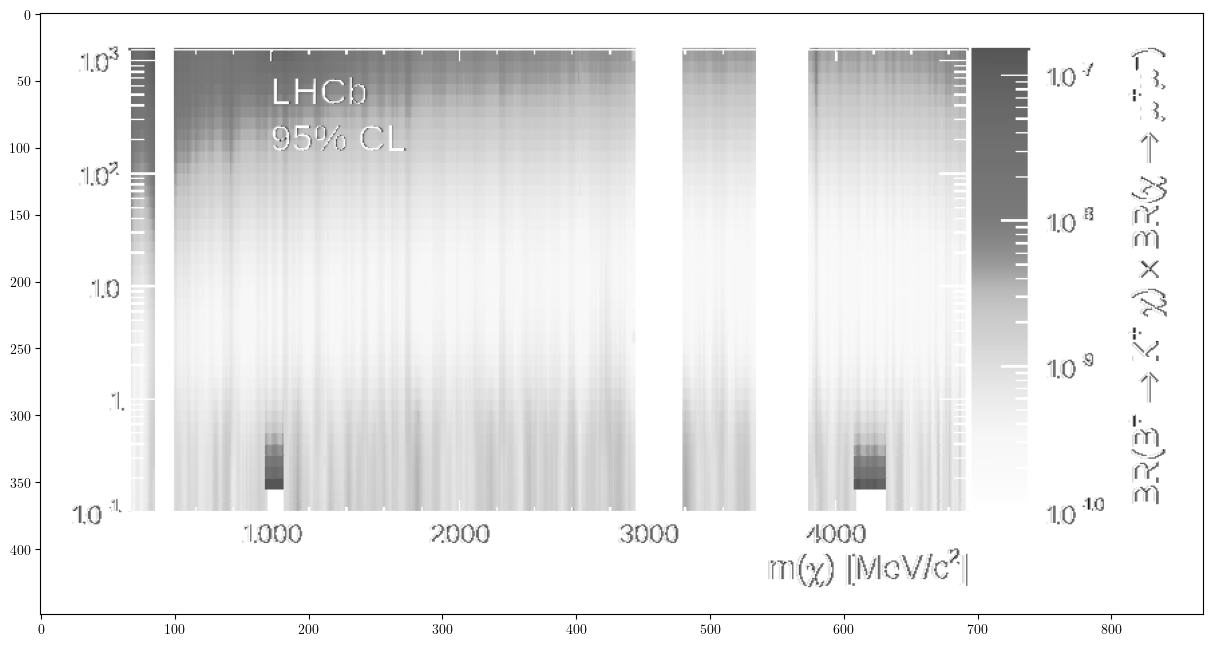

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(np.asarray(imgH)[:,:,0], cmap='binary', vmin=0, vmax=255)

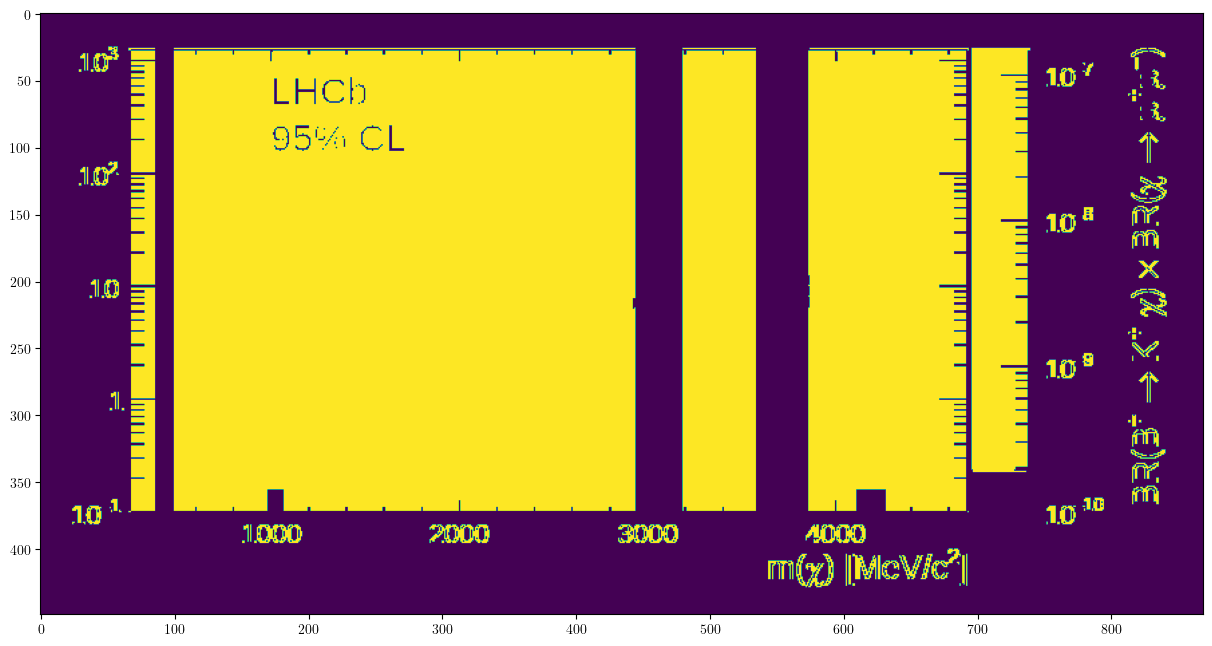

In [11]:
plt.figure(figsize=(15,15))
excluded = np.where(np.asarray(imgH)[:,:,0] < 6, 0, 1)
plt.imshow(excluded)

(0.26066350710900477, 4.696682464454977)

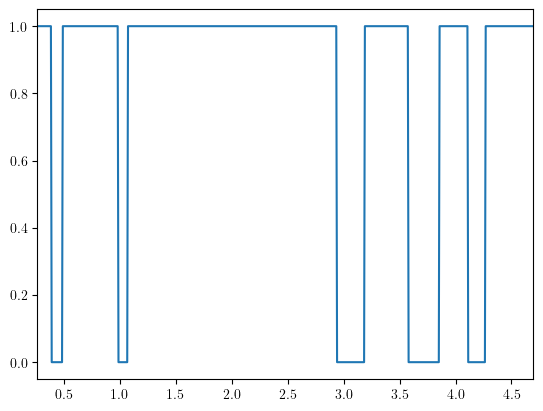

In [12]:
plt.plot([x2ma(x) for x in range(68,692)], excluded[358,68:692])
plt.xlim(x2ma(68), x2ma(692))

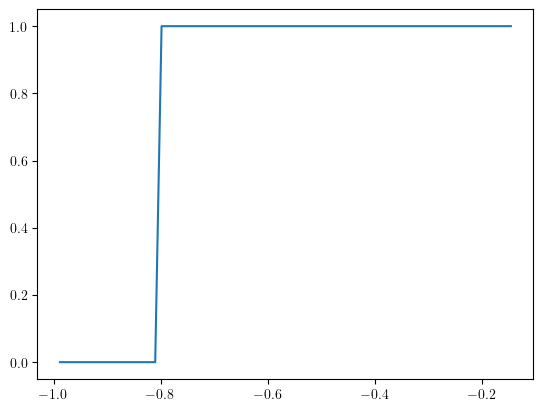

In [13]:
plt.plot([y2logtau(y) for y in range(300, 372)], excluded[300:372, 176])

In [14]:
yres = 300
while excluded[yres,176] == 1:
    yres += 1
logtaures1 = y2logtau(yres)

yres = 300
while excluded[yres,615] == 1:
    yres += 1
logtaures2 = y2logtau(yres)

In [15]:
val = 1
boundaries_ma = []
for x in range(68, 692):
    if excluded[358,x] != val:
        boundaries_ma.append(x2ma(x))
        val = 1-val

## Extract data

In [16]:
ma_list = []
tau_list = []
br_list = []
for x in range(66, 692):
    for y in range(25, 372):
        hue = imgH.getpixel((x,y))[0]
        if hue >= 6:
            ma_list.append(float(x2ma(x)))
            tau_list.append(float(y2logtau(y)))
            br_list.append(float(hue2logbr(hue)))

In [17]:
pd.DataFrame({'ma_GeV': ma_list, 'logtau_ps': tau_list, 'logbr':br_list}).to_csv('data/BKmumu_LHCb.csv', index=False)

## Interpolation

In [23]:
df_saved = pd.read_csv('data/BKmumu_LHCb.csv')
df_saved.head()

,ma_GeV,logtau_ps,logbr
0,0.246445,3.102767,-7.128440
1,0.246445,3.090909,-7.128440
2,0.253555,3.102767,-7.027523
3,0.253555,3.090909,-7.027523
4,0.260664,3.102767,-7.128440


In [24]:
br_LHCb_interp = SmoothBivariateSpline(df_saved['ma_GeV'], df_saved['logtau_ps'], df_saved['logbr'])
def br_LHCb_array(ma, logtau):
    br0 = np.flip(br_LHCb_interp(ma, logtau).T, axis=0)
    xx, yy = np.meshgrid(ma, np.flip(logtau))
    mask_ma = np.where(xx > boundaries_ma[0], 0, 1) + np.where(xx < boundaries_ma[1], 0, 1) + np.where(xx > boundaries_ma[4], 0, 1) + np.where(xx < boundaries_ma[5], 0, 1) + np.where(xx > boundaries_ma[6], 0, 1) + np.where(xx < boundaries_ma[7], 0, 1)
    mask_res1 = np.multiply(np.where(xx < boundaries_ma[2], 0, 1) - np.where(xx > boundaries_ma[3], 1, 0), np.where(yy > logtaures1, 0, 1))
    mask_res2 = np.multiply(np.where(xx < boundaries_ma[8], 0, 1) - np.where(xx > boundaries_ma[9], 1, 0), np.where(yy > logtaures2, 0, 1))
    mask_tot =  -mask_res1 + mask_ma - mask_res2
    return np.ma.masked_array(br0, mask = np.ones(br0.shape)-mask_tot/np.max(mask_tot))

/home/jorge/.local/lib/python3.12/site-packages/scipy/interpolate/_fitpack2.py:1419: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


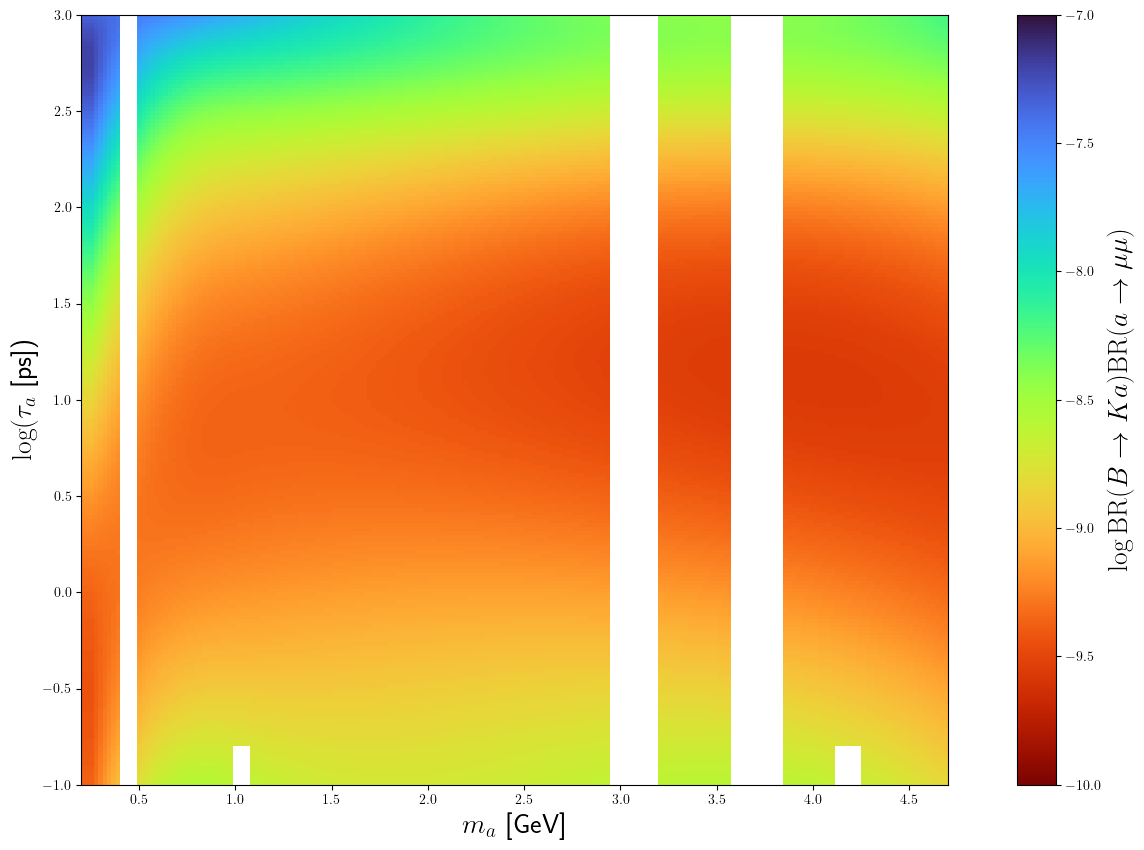

In [25]:
plt.figure(figsize=(18,10))
plt.imshow(br_LHCb_array(np.linspace(0.2, 4.7, 200), np.linspace(-1, 3, 200)), cmap='turbo_r', vmin=-10, vmax=-7, extent=[0.2, 4.7,-1,3])
cbar = plt.colorbar()
plt.xlabel(r'$m_a$ [GeV]', fontsize=20)
plt.ylabel(r'$\log (\tau_a$ [ps])', fontsize=20)
cbar.set_label(r'$\log \mathrm{BR}(B\to Ka) \mathrm{BR}(a\to \mu\mu)$', fontsize=20)